## Introduction

This notebook explores which kinds of players contribute the most gameplay data, using exploratory analysis and a KNN regression plan. The datasets used were kindly given by "a research group in Computer Science at UBC, led by Frank Wood, who is collecting data about how people play video games".

## Descriptive Summary of Dataset

- **Number of observations**: 195 players
- **Number of variables**: 7 (from `players.csv`)
- **Summary statistics** (rounded to 2 decimal places):

| Variable         | Type       | Description                               | Mean / Summary    |
|------------------|------------|-------------------------------------------|-------------------|
| `Age`            | Numeric    | Player's age in years                     | 21.14             |
| `subscribe`      | Categorical| Whether the player is a subscriber        | MOSTLY TRUE       |
| `experience`     | Categorical| Experience with minecraft                 | P/A/V/R           |
| `played_hours`   | Numeric    | Total hours played (summed from sessions) | 5.85, very skewed |
| `hashedEmail`    | Categorical| Unique player identifier                  | eg. f4431d8e21... |
| `name`           | Categorical| Player's first name                       | ex. Nico          |
| `gender`         | Categorical| Player's gender identity                  | m/f/nb/pnts       |

- **Issues observed**:
  - Some sessions have missing or invalid timestamps, leading to `NA` values in `duration` or `total_minutes`
  - A few sessions may have zero or negative durations due to timestamp errors
  - Some players have no session data, resulting in `NA` for `total_minutes`
  - Skewed distribution of `total_minutes` — most players contribute little, a few contribute a lot
  - Possible outliers in age or experience

- **Potential unseen issues**:
  - Selection bias: players in the dataset may not represent the full population
  - Measurement error: session durations may be inaccurate if timestamps are off
  - Missing context: we don’t know how players were recruited or what motivates their playtime
  - Session overlap: Players might have overlapping sessions that inflate total time
  - Bot or idle activity: Unusually long or frequent sessions could reflect non-human behavior

- **How the data were collected**:
  - Based on session logs and player profiles from a game platform
  - New columns (`start_date`, `end_date`, `duration`) were created to support analysis
  - Merged with `players.csv` using `hashedEmail` to compute `total_minutes` per player
  - Timestamps were provided in both human-readable and Unix formats

## Descriptive Summary of the Sessions Dataset

- **Number of observations**: Over 10,000 session records (exact count from `sessions.csv`)
- **Number of variables**: 6 (from `sessions.csv`)
- **Summary statistics** (rounded to 2 decimal places):

| Variable             | Type       | Description                                 | Mean / Summar   |
|----------------------|------------|---------------------------------------------|-----------------|
| `hashedEmail`        | Categorical| Unique session identifier                   | eg. f4431d8...  |
| `duration_mins`      | Numeric    | Session duration in minutes                 | 50.86           |
| `start_time`         | Datetime   | Session start timestamp                     | 30/06/2024 18:12|
| `end_time`           | Datetime   | Session end timestamp                       | 30/06/2024 18:24|
| `original_start_time`| Numeric    | Unix timestamp of session start (millisecs) | 1.71977E+12     |
| `original_end_time`  | Numeric    | Unix timestamp of session end (millisecs)   | 1.71977E+12     |
| `start_date`         | Date       | Extracted date portion from `start_time`    | 2024-06-30      |
| `end_date`           | Date       | Extracted date portion from `end_time`      | 2024-06-30      |
| `start_time`         | Time       | Extracted time portion from `start_time`    | 18:12           |
| `end_time`           | Time       | Extracted time portion from `end_time`      | 18:24           |
| `total_minutes`      | Numeric    | Sum of all session durations per player     | 623.73          |
| `session_count`      | Numeric    | Sum of all sessions per player              | 12.28           |

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players<-read_csv("data/players.csv")

sessions<-read_csv("data/sessions.csv")|>
    separate(start_time,into=c("start_date","start_time"),sep=" ")|>
    separate(end_time,into=c("end_date","end_time"),sep=" ")|>
        mutate(
            start_dt = as.POSIXct(paste(start_date,start_time),format="%d/%m/%Y %H:%M"),
            end_dt = as.POSIXct(paste(end_date,end_time),format="%d/%m/%Y %H:%M"),
            duration_mins = as.numeric(difftime(end_dt,start_dt,units="mins"))
        )

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
player_sessions<-sessions|>
    group_by(hashedEmail) |>
    summarise(
    total_minutes = sum(duration_mins, na.rm = TRUE),
    session_count = n()
    )
player_sessions|>
    summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))

total_minutes,session_count
<dbl>,<dbl>
623.73,12.28


In [4]:
full_data<-players|>
    left_join(player_sessions,by="hashedEmail")
head(full_data)


experience,subscribe,hashedEmail,played_hours,name,gender,Age,total_minutes,session_count
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2019,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,255,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [5]:
summary(sessions$duration_mins)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   3.00    9.00   30.00   50.86   73.00  259.00       2 

In [6]:
players|>
    summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))

played_hours,Age
<dbl>,<dbl>
5.85,21.14


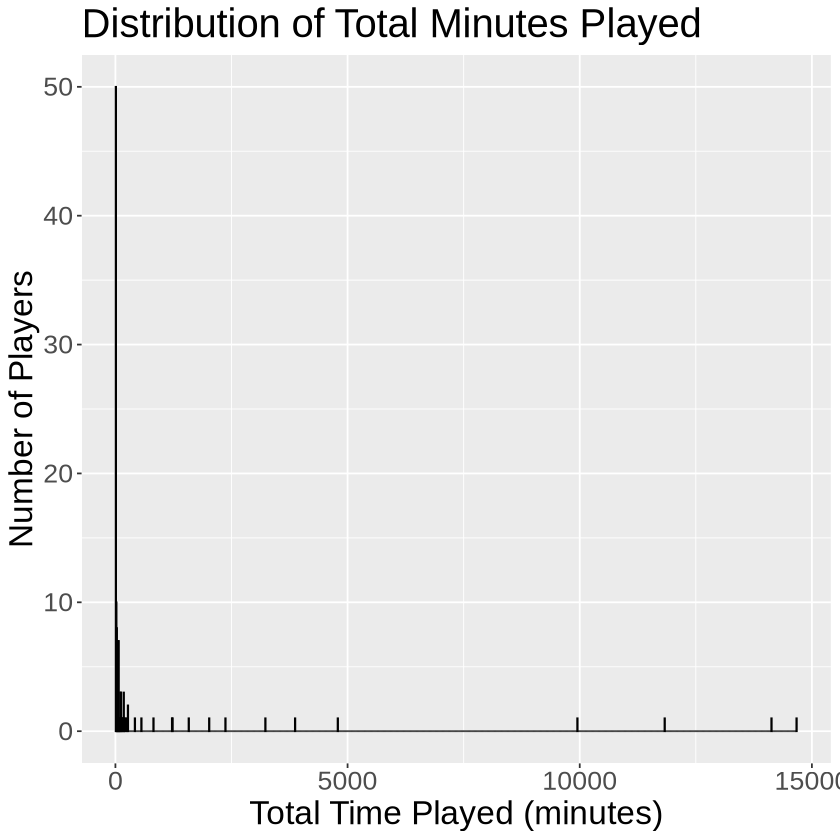

In [7]:
total_mins_histogram<-ggplot(full_data |> filter(!is.na(total_minutes)), aes(x = total_minutes)) +
    geom_histogram(binwidth = 10, fill = "steelblue", color = "black") +
    labs(title = "Distribution of Total Minutes Played",
         x = "Total Time Played (minutes)",
         y = "Number of Players")+
    theme(text=element_text(size=20))
total_mins_histogram

The distribution of total minutes played is highly right-skewed. 
Most players contribute relatively little gameplay data, but it seems that a small number of players contribute disproportionately high amounts. 
This suggests that identifying and targeting high-contributing players could, and likely would, be impactful recruitment efforts

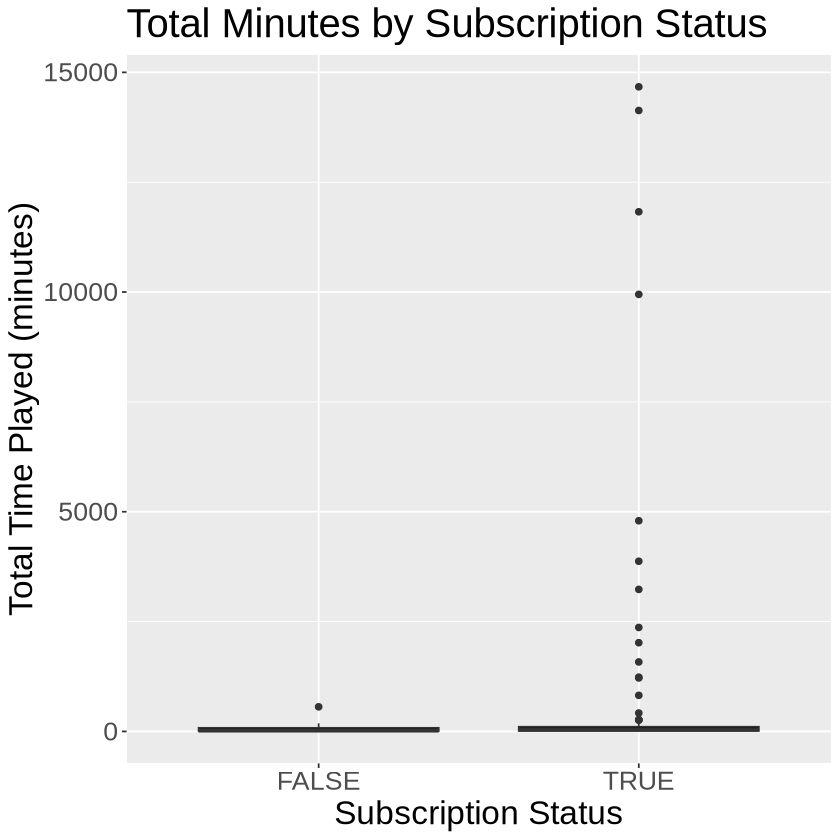

In [8]:
total_mins_boxplot <- ggplot(full_data |> filter(!is.na(total_minutes)), aes(x = subscribe, y = total_minutes)) +
    geom_boxplot(fill = "black") +
    labs(title = "Total Minutes by Subscription Status",
         x = "Subscription Status",
         y = "Total Time Played (minutes)")+
    theme(text=element_text(size=20))
total_mins_boxplot

Subscribers tend to have higher total minutes played compared to non-subscribers. There is larger clustering of players who have played less time, but significantly more people who are subscribed engage in the game more. There are is very few time recorded of players who are not subscribed, therefore subscription status is likely a high predictor of gameplay contribution

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


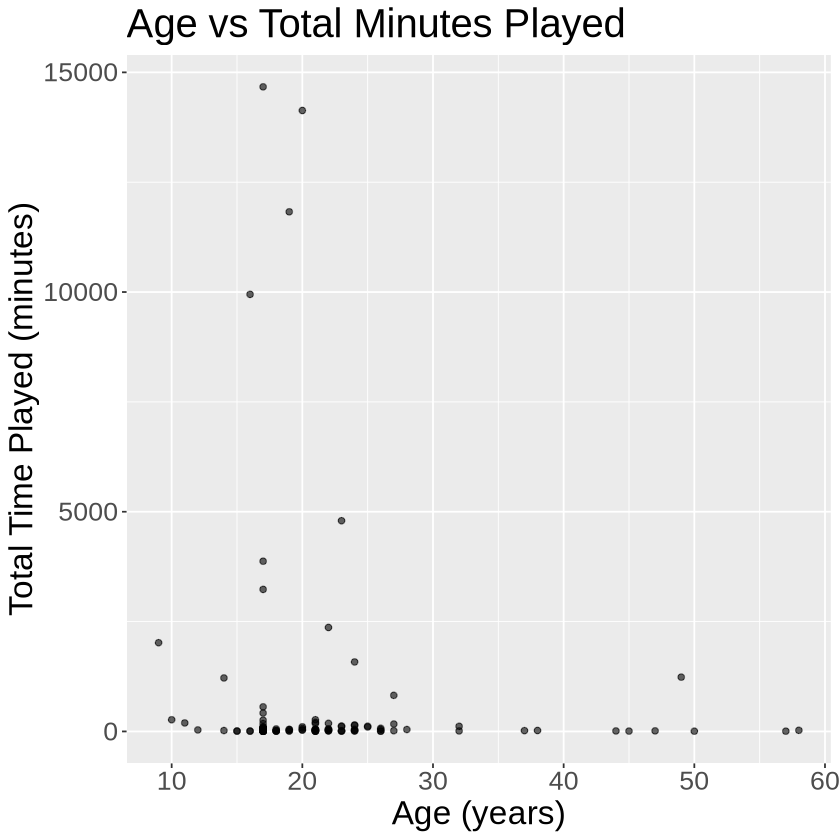

In [9]:
total_mins_scatterplot<-ggplot(full_data |> filter(!is.na(total_minutes)), aes(x = Age, y = total_minutes)) +
  geom_point(alpha = 0.6, color = "black") +
  labs(title = "Age vs Total Minutes Played",
       x = "Age (years)",
       y = "Total Time Played (minutes)")+
    theme(text=element_text(size=20))
total_mins_scatterplot

Most people who game are young adults, teenage to late 20s age. There is no clear linear relationship between age and total minutes, but a few older players seem to be high contributors. This suggests age may interact with other traits, like experience or subscription status. 

# Methods and Plan

My broad question is #2: "We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts."

To address my specific question — which kinds of players (age, subsciption status, time spent gaming) contribute the most gameplay data — I plan to use K-Nearest Neighbors (KNN) regression. This method is appropriate because my response variable (total_minutes) is continuous, and KNN can capture nonlinear relationships between player traits and gameplay contribution.

Why KNN is appropriate:
- It makes no assumptions about the underlying data distribution
- It can model complex relationships between predictors and response

Assumptions:
- The data is scaled appropriately (KNN is sensitive to scale)
- Similar players have similar behavior

Limitations:
- Sensitive to irrelevant features and noise
- Performance depends on the choice of k and distance metric

Model comparison and validation:
- I will split the data into training and test sets (80/20 split)
- I will use cross-validation to select the best value of k
- I will evaluate performance using RMSE and R²


## GitHub Summary

This notebook was developed with version control using GitHub. I made at least five commits to track progress, including data loading, cleaning, visualization, and writing. The final version is pushed to my GitHub repository.